In [1]:
%matplotlib notebook

In [2]:
import json

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

from kafka import KafkaConsumer


In [3]:
def readFromKafka(topic):
    consumer = KafkaConsumer(topic, 
                             bootstrap_servers="master1:6667", 
                             auto_offset_reset='earliest', 
                             enable_auto_commit=True, 
                             value_deserializer=lambda x: x.decode('utf-8'), 
                             consumer_timeout_ms=10000)

    records = []
    for message in consumer:
        record = json.loads(message.value)
        record["KafkaTimestamp"] = message.timestamp
        records.append(record)

    # Normalize timestamp
    df = json_normalize(records)
    
    base = df["Timestamp"].loc[0:0][0]
    df["EventTimestamp0"] = (df["Timestamp"] - base) / 1000.0
    df["ReceivedTimestamp0"] = (df["KafkaTimestamp"] - base ) / 1000.0

    print(f"Records: {len(records)}")
    return df

In [4]:
from matplotlib.ticker import MaxNLocator

def plotComparision(data, height=14):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,figsize=(10,height))

    ax1.scatter( x='EventTimestamp0', y='ClientID', c='ClientID', data=data, marker='o', alpha=0.5, cmap="tab20")
    ax1.title.set_text('Event Timestamp (zero normalized)')

    ax2.scatter( x='ReceivedTimestamp0',y='ClientID', c='ClientID', data=data, marker='o', alpha=0.5, cmap="tab20")
    ax2.title.set_text('Received Timestamp (zero normalized)')

    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()
    return (ax1, ax2)

## Analyse a 10 session dataset from 10 clients

In [5]:
df = readFromKafka('sessions-10')
df.head()

Records: 229


,ClientID,Data.Errors,Data.Values,EventID,KafkaTimestamp,Kind,SessionID,Timestamp,EventTimestamp0,ReceivedTimestamp0
0,1,0,69,1,1540972741657,d,e5f60ce5-c724-41ef-b78b-f13cb180bd43,1540972741645,0.000,0.012
1,1,0,61,2,1540972744493,d,e5f60ce5-c724-41ef-b78b-f13cb180bd43,1540972744486,2.841,2.848
2,1,0,15,3,1540972744502,d,e5f60ce5-c724-41ef-b78b-f13cb180bd43,1540972744494,2.849,2.857
3,4,0,20,1,1540972745026,d,5f126715-936e-4163-801e-1a753f04e7e6,1540972745015,3.370,3.381
4,8,0,85,1,1540972745148,d,bcb68dd3-01ea-4770-b66a-5bc33eb21ff7,1540972745144,3.499,3.503


### Distribution of session lenghts

<IPython.core.display.Javascript object>


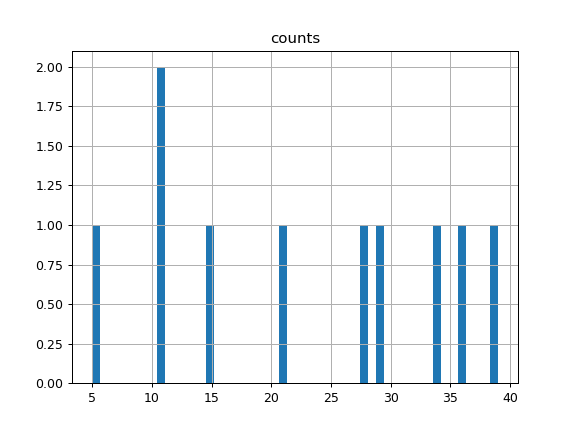

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e302860>]],
      dtype=object)

In [6]:
hist = df.groupby(by="SessionID").size().reset_index(name='counts').sort_values(by="counts")
hist.hist(bins=50)

### Comparison of Event time and Receoved Time

<IPython.core.display.Javascript object>


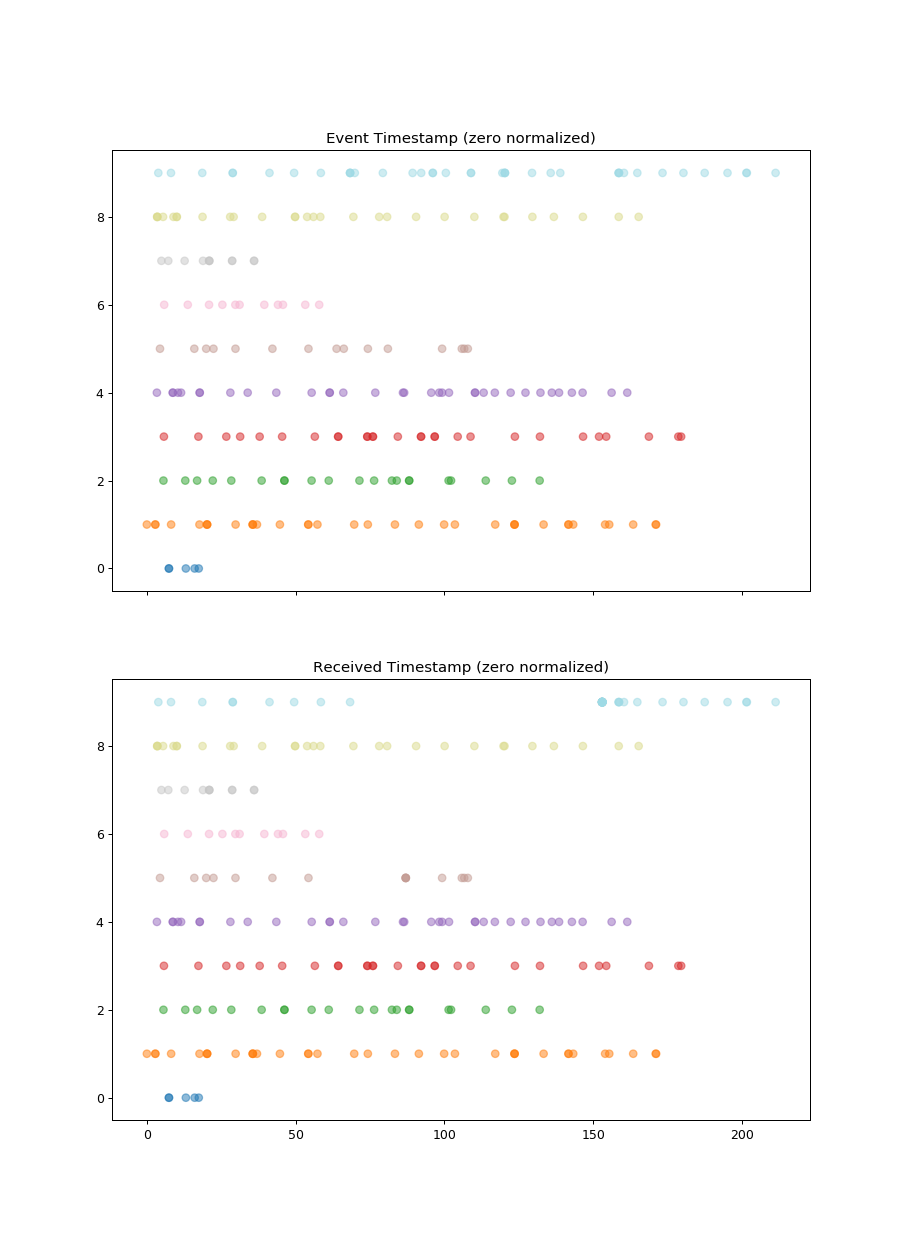

In [7]:
axes = plotComparision(df)

**Session 2 shows a "network outage" after 70 seconds of about 80 seconds**

<IPython.core.display.Javascript object>


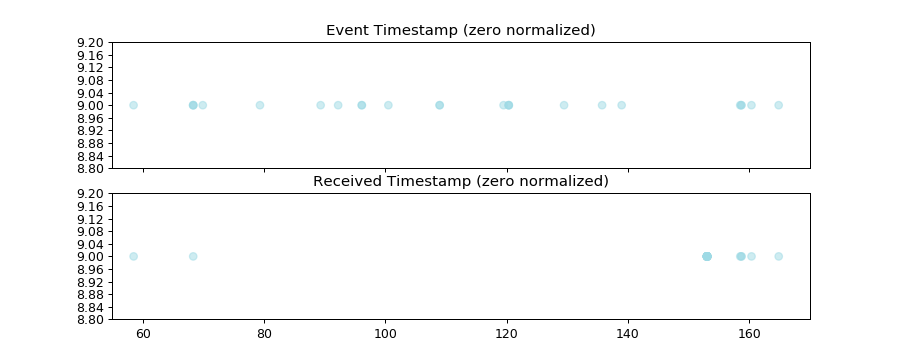

(55, 170)

In [8]:
axes = plotComparision(df, 4)
axes[0].set_ylim([8.8,9.2])
axes[0].set_xlim([55,170])

**The data was buffered by the client and sent as fast as possible at about 153 sec**

<IPython.core.display.Javascript object>


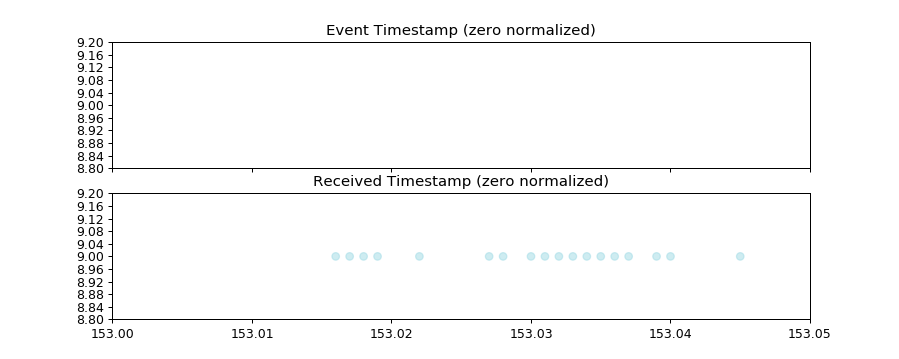

(153, 153.05)

In [9]:
axes = plotComparision(df, 4)
axes[0].set_ylim([8.8,9.2])
axes[0].set_xlim([153,153.05])

<IPython.core.display.Javascript object>


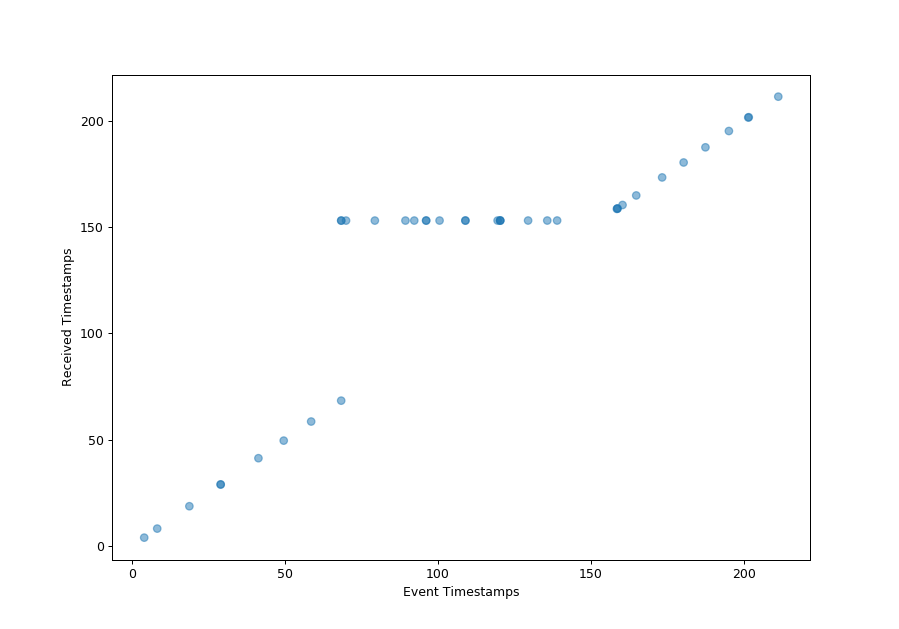

In [10]:
def plotERComparision(data, height=14):
    fig = plt.figure(figsize=(10,height))

    plt.scatter( x='EventTimestamp0', y='ReceivedTimestamp0', c='ClientID', data=data, marker='o', alpha=0.5, cmap="tab20")
    plt.xlabel("Event Timestamps")
    plt.ylabel("Received Timestamps")
    plt.show()

plotERComparision(df[df.ClientID == 9], 7)

## Analyze a 100 sessions dataset from 10 clients

In [10]:
df = readFromKafka('sessions-100')

Records: 2428


<IPython.core.display.Javascript object>


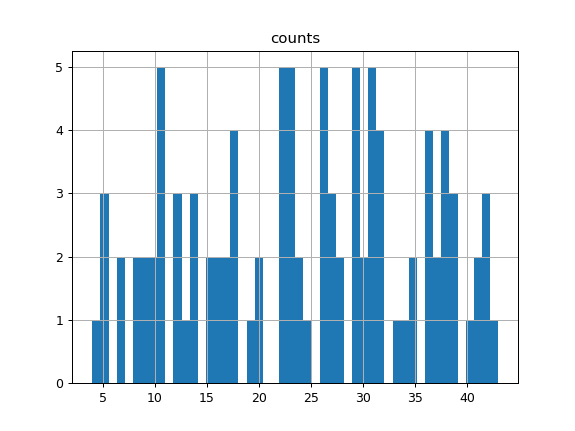

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1228fdc18>]],
      dtype=object)

In [11]:
hist = df.groupby(by="SessionID").size().reset_index(name='counts').sort_values(by="counts")
hist.hist(bins=50)

<IPython.core.display.Javascript object>


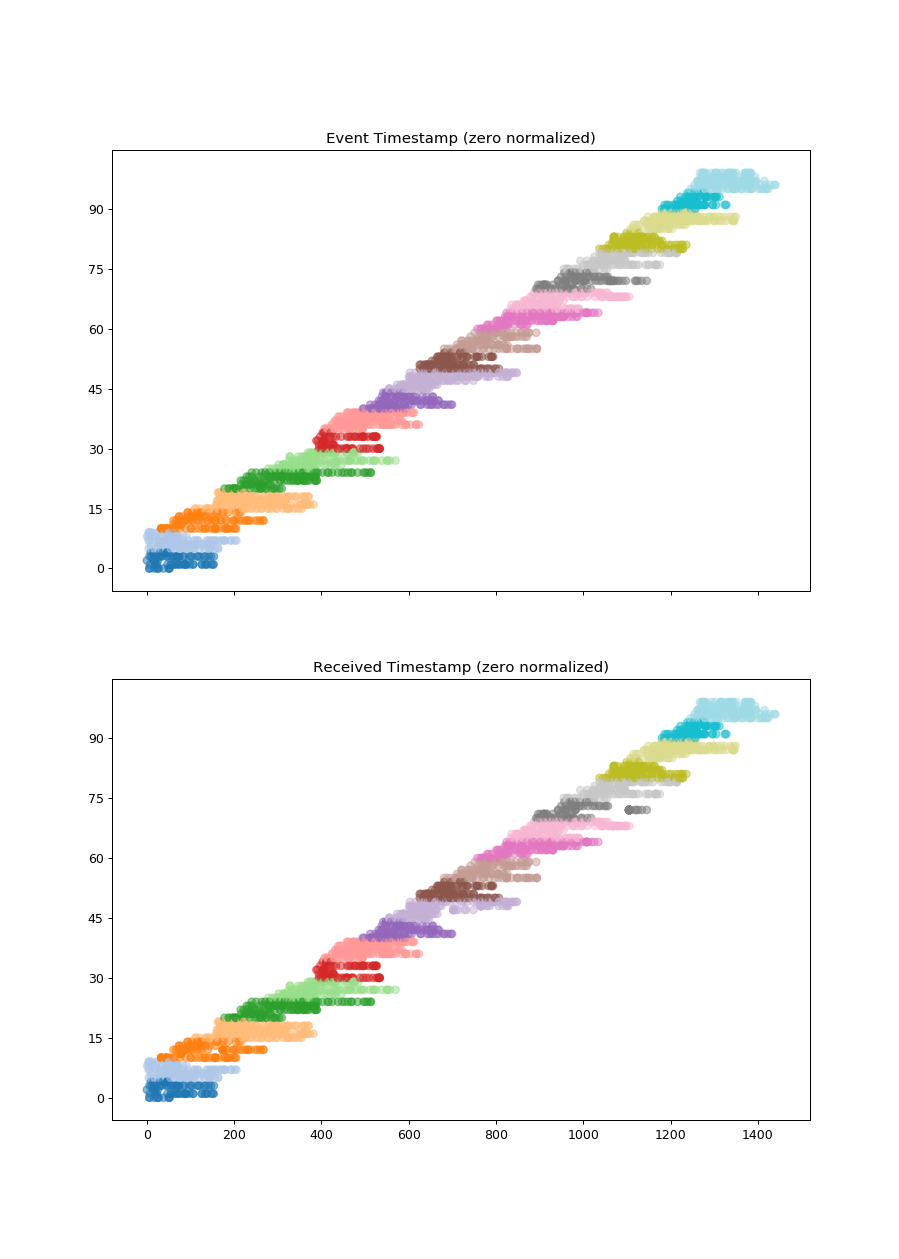

In [12]:
plotComparision(df)